# Accuracy

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from IPython.display import clear_output
import ipywidgets as widgets
import os
import math

In [2]:
plt.rcParams["figure.figsize"] = (16,8)

In [3]:
def checkPrediction(prediction, label):
    correctness = 0
    if len(label) == 1 and len(prediction) == 1:
        correctness = int(abs(label[0] - prediction[0]) < 0.1)
    elif len(label) == 1 and len(prediction) != 1:
        correctness = int(label[0] == np.argmax(prediction))
    elif len(label) != 1 and len(prediction) != 1:
        correctness = int(np.argmax(label) == np.argmax(prediction))
    return correctness

In [56]:
dirs = [d for d in sorted(os.listdir('.')) if os.path.isdir(d)]
wFolder = widgets.Dropdown(
    options=dirs,
    description='Experiment:',
)
display(wFolder)

Dropdown(description='Experiment:', options=('.ipynb_checkpoints', 'RadonMachine', 'hessianCifar100Exp_2019-05…

In [57]:
experimentFolder = wFolder.value
print(experimentFolder)

hessianCifar100Exp_2019-05-22_11-22-01


In [58]:
nodesAmount = 0
dirs = [d for d in os.listdir(experimentFolder) if os.path.isdir(os.path.join(experimentFolder,d))]
for d in dirs:
    if 'worker' in d:
        nodesAmount += 1
print("Learners amount is ", str(nodesAmount))

Learners amount is  2


## Mean Accuracy Aligned by Amount of Examples Seen

In [59]:
displayStep = 100000
# should be larger or equal to displayStep or it will just record same image several times
recordStep = 100000
recordUnique = False

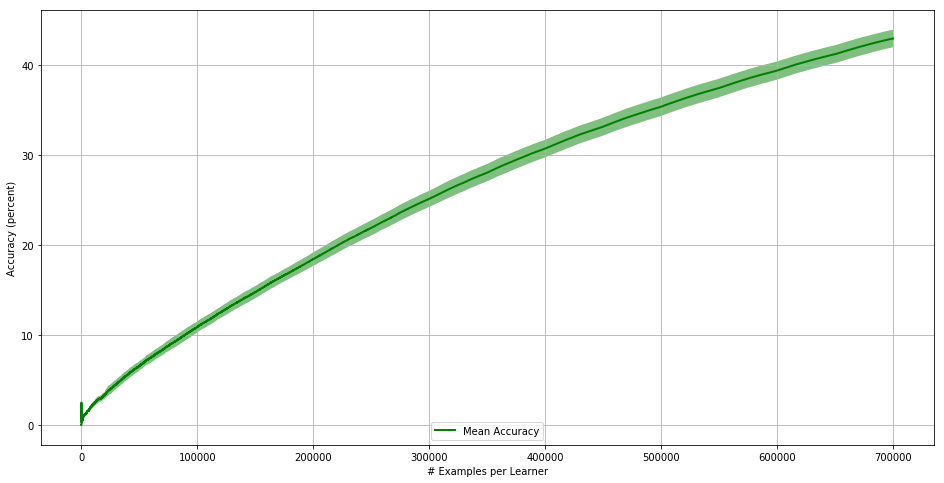

In [ ]:
files = []
correctSums = []
accuracies = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "predictions.txt"), "r"))
    accuracies.append([0])
    correctSums.append([0])
t = [0]
commonStep = 0

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        else:
            pred = [float(x) for x in line[:-1].split('\t')[1].split(',')]
            label = [float(x) for x in line[:-1].split('\t')[2].split(',')]
            correctness = checkPrediction(pred, label)
            correctSums[i].append(correctSums[i][-1] + correctness)
            accuracies[i].append(correctSums[i][-1]*100.0/(commonStep+1))
    currentStep = min([len(a) for a in accuracies])
    if currentStep > commonStep:
        commonStep = currentStep
        if commonStep % displayStep == 0:
            clear_output(wait=True)
            cutAccuracies = [a[1:commonStep] for a in accuracies]
            mu = np.array(cutAccuracies).mean(axis=0)
            sigma = np.array(cutAccuracies).std(axis=0)
            fig = plt.figure()
            plt.plot(t, mu, lw=2, label='Mean Accuracy', color='green')
            plt.fill_between(t, mu+sigma, mu-sigma, facecolor='green', alpha=0.5)
            plt.legend(loc='lower center')
            plt.xlabel("# Examples per Learner")
            plt.ylabel("Accuracy (percent)")
            plt.grid()
            plt.show()
        t.append(t[-1] + 1)
        if commonStep % recordStep == 0:
            if recordUnique:
                fig.savefig(os.path.join(experimentFolder, 'accuracy' + str(commonStep) + '.png'), dpi=100)
            else:
                fig.savefig(os.path.join(experimentFolder, 'accuracy.png'), dpi=100)

In [ ]:
for file in files:
    file.close()

## System Accuracy Aligned by Time

There is not such thing as average accuracy aligned by time, until unless we are counting accuracy individually for each learner. So this plot does not have mean and deviation - it is just one line of development of accuracy for the whole system.

In [ ]:
# setup of the plots saving
displayStep = 1
recordStep = 10
recordUnique = False
uniqueImageCounter = 0
# draw a point for every second of experiment time
frequencyStep = 2
displaySync = True

In [ ]:
# get zero timestamp, i.e., beginning of the experiment
expSummary = open(os.path.join(experimentFolder,"summary.txt")).read()
for l in expSummary.split("\n"):
    if "Start" in l:
        startTimestamp = float(l.split("\t")[-1][:-1])
        break

In [ ]:
files = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "predictions.txt"), "r"))

if displaySync:
    syncFile = open(os.path.join(experimentFolder, "coordinator", "communication", "send_model.txt"), "r")

In [ ]:
# we have zero accuracy at the beginning
plot = [0]
# in order to avoid division by 0 we start with amount 1 - but that slightly decreases accuracy, since 
# amount is always larger by 1
amounts = [1]
syncPoints = []
change = False
while True:
    for f in files:
        where = f.tell()
        line = f.readline()
        if line:
            change = True
            parsedLine = line[:-1].split("\t")
            lineTimestamp = float(parsedLine[0])
            # identify to which point in time this line will go
            xPoint = math.ceil((lineTimestamp - startTimestamp) / frequencyStep)
            
            pred = [float(x) for x in parsedLine[1].split(',')]
            label = [float(x) for x in parsedLine[2].split(',')]
            correctness = checkPrediction(pred, label)

            if len(plot) < xPoint:
                for i in range(xPoint - len(plot)):
                    plot.append(plot[-1])
                    amounts.append(amounts[-1])
            for i in range(len(plot) - xPoint + xPoint, xPoint + 1, 1):
                plot[i-1] += correctness
                amounts[i-1] += 1
    if displaySync:
        where = syncFile.tell()
        line = syncFile.readline()
        if line:
            parsedLine = line[:-1].split("\t")
            lineTimestamp = float(parsedLine[0])
            # if model was sent only to one learner it is not a synchronization
            if parsedLine[2].count(".") > 1:
                syncPoints.append(math.ceil((lineTimestamp - startTimestamp) / frequencyStep))
          
    # do not need to call plotting if no new lines were read
    if not change:
        time.sleep(1)
        continue

    change = False
    if len(plot) % displayStep == 0:
        clear_output(wait=True)
        fig = plt.figure()
        accuracies = np.array(plot) * 100.0 / np.array(amounts)
        plt.plot(range(len(plot)), accuracies, label='Accuracy', color='green')
        if displaySync:
            displayedSyncs = [p for p in syncPoints if p < len(plot)]
            plt.scatter(displayedSyncs, accuracies[displayedSyncs], color='blue', alpha=0.6, lw=5, s=2500, marker='|')
        plt.legend(loc='lower center')
        plt.xlabel("Time (every " + str(frequencyStep) + "s)")
        plt.ylabel("Accuracy (percent)")
        plt.grid()
        plt.show()
    if len(plot) % recordStep == 0:
        if recordUnique:
            fig.savefig(os.path.join(experimentFolder, 
                                     'accuracy_time' + str(uniqueImageCounter) + '.png'), dpi=100)
            uniqueImageCounter += 1
        else:
            fig.savefig(os.path.join(experimentFolder, 'accuracy_time.png'), dpi=100) 

In [ ]:
for file in files:
    file.close()

if displaySync:
    syncFile.close()